In [1]:
var openDigger = require('../../src/open_digger');
var now = new Date();
var res = now.setMonth(now.getMonth() - 1); // handle new year
var startYear = 2022, startMonth = 1, endYear = now.getFullYear(), endMonth = now.getMonth() + 1;
var forEveryMonth = f => {
    var index = 0;
    for (var y = startYear; y <= endYear; y++)
        for (var m = (y === startYear ? startMonth : 1); m <= (y === endYear ? endMonth : 12); m++)
            f(y, m, index++);
};

# X-lab Community Analysis Report

This notebook is used to track the members active and influence status in X-lab community.

The result can be used for community measurement and incentive.

The start date for this report is 2022-01-01 and the end date is up-to-date.

## Overview

This part is the history OpenRank trending of all projects in X-lab community.

┌─────────┬─────────────┬─────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬──────────┬──────────┬──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ (index) │     id      │                name                 │ Y2022M1 │ Y2022M2 │ Y2022M3 │ Y2022M4 │ Y2022M5 │ Y2022M6 │ Y2022M7 │ Y2022M8 │ Y2022M9 │ Y2022M10 │ Y2022M11 │ Y2022M12 │ Y2023M1 │ Y2023M2 │ Y2023M3 │ Y2023M4 │ Y2023M5 │ Y2023M6 │
├─────────┼─────────────┼─────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┼──────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│    0    │ '288431943' │       'X-lab2017/open-digger'       │  4.71   │  4.87   │  6.06   │  3.76   │  4.14   │  7.67   │  9.17   │  8.53   │  9.96   │  11.84   │  14.65   │  19.36   │  19.9   │  40.48  │  22.05  │  18.79  │  18.42  │  14.3   │
│    1    │ 

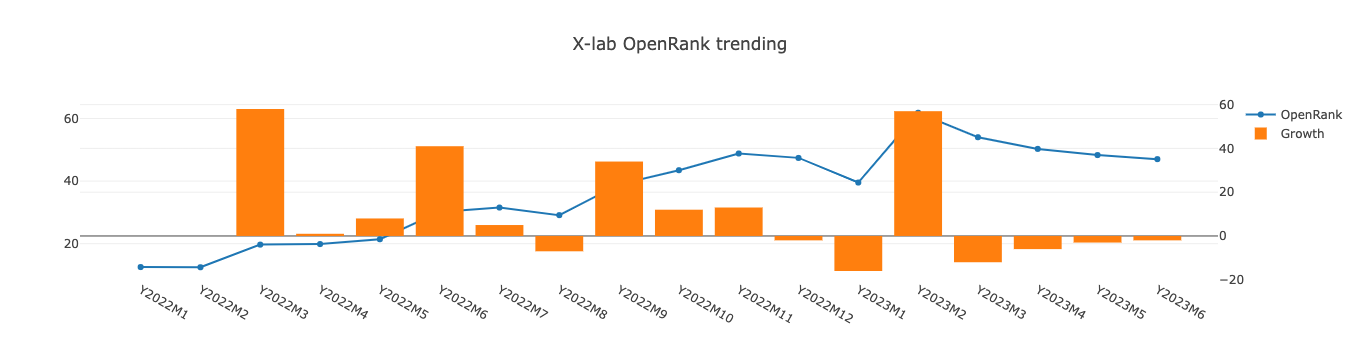

2022.7 based growth: 0.40,0.40,0.62,0.63,0.68,0.96,1.00,0.92,1.23,1.38,1.55,1.50,1.25,1.96,1.71,1.59,1.53,1.49


In [2]:
openDigger.index.openrank.getRepoOpenrank({
    repoIds: [288431943, 470364208, 467768946, 461374162, 471252840, 477937218, 428629051, 262909684, 221379769, 259035151, 358757145, 502755745, 508325123, 533339106, 572845686, 639923640 ],
    startYear, startMonth,
    endYear, endMonth, percision: 2,
    groupTimeRange: 'month', limit: -1, order: 'DESC',
}).then(data => {
    var x = [], v = [], g = []; g.push(0);
    forEveryMonth((y, m, index) => {
        var key = `Y${y}M${m}`;
        x.push(key); v.push(0);
        data.forEach(row => { v[index] += (row.openrank[index] ? row.openrank[index] : 0); row[key] = row.openrank[index] ? row.openrank[index] : 0; });
        if (index > 0) g.push(Math.ceil((v[index]-v[index-1])*100/v[index-1]));
    });
    data.forEach(row => { delete row.openrank; delete row.org; });
    console.table(data);
    openDigger.render.plotly([
        { x, y: v, type: 'scatter', name: 'OpenRank' },
        { x, y: g, type: 'bar', yaxis: 'y2', name: 'Growth'}
    ], {
        title: 'X-lab OpenRank trending',
        yaxis2: { overlaying: 'y', side: 'right' }
    });
    console.log(`2022.7 based growth: ${v.map(i => (i/v[6]).toFixed(2))}`);
    fs.writeFileSync('all_data.json', JSON.stringify(data));
});

## OpenRank Distribution

The OpenRank distribution for certain month is calculated by every repo with OpenRank in this month and all the developers' OpenRank in these repos in this month.

The algorithm means:

- If you contribute to a high OpenRank repo, your final OpenRank may higher.
- If you contribute more in any repo, your final OpenRank may higher.
- If you have a high OpenRank in a certain repo, make the repo's OpenRank higher, your OpenRank will be higher.

So please contribute more and contribute to the important repos, or make your own repo important.

In [3]:
var calculateOpenRankDistribution = (y, m, base) => {
    var actors = openDigger.label.getGitHubData([':communities/xlab']).githubUsers;
    var key = `Y${y}M${m}`;
    var repos = JSON.parse(fs.readFileSync('all_data.json').toString()).filter(row => row[key] > 0);
    var actorOpenrankMap = new Map();
    var actorLoginMap = new Map();
    var repoArr = [];
    var nextMonth = new Date(`${y}-${m}-1`);
    nextMonth.setMonth(nextMonth.getMonth() + 1);
    actors.forEach(id => actorOpenrankMap.set(id, 0));
    Promise.all(repos.map(r => {
        return new Promise(resolve => {
            var sql = `MATCH (u:User)
            WHERE apoc.any.property(u, 'open_rank_${r.id}_${y}${m}') > 0
            AND EXISTS { MATCH (u)-[a:ACTION]->()-[:BELONG]->(r:Repo{id:${r.id}}) WHERE datetime({year:${nextMonth.getFullYear()},month:${nextMonth.getMonth() + 1}})>datetime(a.time)>=datetime({year:${y},month:${m}}) }
            RETURN u.id AS id, u.login AS login, apoc.any.property(u, 'open_rank_${r.id}_${y}${m}') AS openrank`;
            openDigger.driver.neo4j.query(sql).then(data => {
                var total = 0;
                var devs = [];
                data.forEach(item => total += item.openrank);
                data.filter(item => actors.includes(item.id)).forEach(item => {
                    actorLoginMap.set(item.id, item.login);
                    var openrank = item.openrank / total;
                    actorOpenrankMap.set(item.id, actorOpenrankMap.get(item.id) + r[key] * openrank);
                    devs.push({login: item.login, openrank });
                });
                if (devs.length > 0)
                    repoArr.push({ name: r.name, openrank: r[key], devsOrigin: devs, devs: devs.sort((a, b) => b.openrank - a.openrank).map(i => `${i.login}(${(i.openrank*100).toFixed(2)}%)`).join(',')});
                resolve();
            });
        });
    })).then(() => {
        var arr = [];
        var total = 0;
        for (var [ id, openrank ] of actorOpenrankMap.entries()) {
            arr.push({login: actorLoginMap.get(id), openrank});
            total += openrank;
        }
        repoArr.sort((a,b) => b.openrank - a.openrank).forEach(r => console.log(r.name, r.openrank, r.devs));
        console.table(arr.map(i => { return { ...i, ratio: (i.openrank*100/total).toFixed(2) + '%', final: Math.round(i.openrank * base / total) } }).filter(i => i.login).sort((a, b) => b.openrank - a.openrank));
        var detail = {};
        if (fs.existsSync('./detail.json')) detail = JSON.parse(fs.readFileSync('./detail.json').toString());
        detail[`${y}-${m}`] = {
            period: (y === 2022) ? (m - 5) : ((y - 2022 - 1) * 12 + 7 + m),
            reward: base,
            total: arr.filter(i => i.login).sort((a, b) => b.openrank - a.openrank),
            detail: repoArr.map(r => { return { name: r.name, openrank: r.openrank, actors: r.devsOrigin }; }),
        }
        fs.writeFileSync('./detail.json', JSON.stringify(detail));
    });
};

## The OpenRank distibution

In [10]:
calculateOpenRankDistribution(2022, 6, 10000);

X-lab2017/open-research 7.83 will-ww(39.16%),birdflyi(19.43%),xiaoya-yaya(9.53%),frank-zsy(6.17%),JingbenShi668(5.44%),zhuxiangning(4.55%),bifenglin(4.50%),kongzhongsanbu(2.96%),wengzhenjie(2.41%),AliceCodeZhang(2.31%),tyn1998(1.63%),gymgym1212(0.81%),longyanz(0.48%)
X-lab2017/open-digger 7.67 frank-zsy(57.13%),xiaoya-yaya(11.64%),Best-Eminem(3.05%),xgdyp(1.04%),gymgym1212(0.82%),bifenglin(0.43%),tyn1998(0.38%),birdflyi(0.15%),zhicheng-ning(0.15%),chunchill(0.15%),soobun(0.15%),wangleo61(0.15%),kongzhongsanbu(0.07%),wengzhenjie(0.07%)
hypertrons/hypertrons-crx 7.65 tyn1998(57.31%),wxharry(7.73%),zhicheng-ning(4.64%),xgdyp(2.66%),frank-zsy(2.29%),will-ww(0.46%)
X-lab2017/open-leaderboard 2.19 gymgym1212(80.05%),will-ww(11.34%),tyn1998(3.28%),frank-zsy(1.47%)
X-lab2017/open-wonderland 1.85 will-ww(37.44%),xiaoya-yaya(24.11%),xgdyp(11.21%),soobun(8.82%),tyn1998(6.82%),gymgym1212(5.68%),zhicheng-ning(3.08%),zhuxiangning(2.84%)
X-lab2017/open-perf 0.93 bifenglin(53.66%),will-ww(34.27%),fran

In [11]:
calculateOpenRankDistribution(2022, 7, 10000);

X-lab2017/open-digger 9.17 frank-zsy(51.79%),yoyo-wu98(8.70%),longyanz(5.88%),xiaoya-yaya(3.38%),Best-Eminem(2.15%),xgdyp(1.12%),zhuxiangning(0.97%),zhicheng-ning(0.23%)
hypertrons/hypertrons-crx 8.18 tyn1998(66.22%),wxharry(9.50%),xgdyp(4.10%),zhicheng-ning(3.18%),frank-zsy(2.07%),will-ww(0.89%)
X-lab2017/open-wonderland 5.46 will-ww(54.17%),bifenglin(14.15%),xiaoya-yaya(12.44%),TieWay59(3.72%),xgdyp(2.21%),wangleo61(2.10%),frank-zsy(1.58%),kongzhongsanbu(1.24%),tyn1998(1.24%),birdflyi(1.03%),yoyo-wu98(1.03%),longyanz(0.94%),zhicheng-ning(0.84%),gymgym1212(0.82%),JingbenShi668(0.73%)
X-lab2017/open-research 3.71 will-ww(48.61%),bifenglin(24.31%),yoyo-wu98(8.22%),xgdyp(2.16%)
X-lab2017/open-leaderboard 1.97 gymgym1212(68.75%),will-ww(31.25%)
OpenEduTech/EduTechResearch 0.7 soobun(59.28%),will-ww(30.36%),AliceCodeZhang(10.36%)
X-lab2017/open-perf 0.48 bifenglin(64.67%),will-ww(35.33%)
┌─────────┬──────────────────┬──────────────────────┬──────────┬───────┐
│ (index) │      login       │

In [12]:
calculateOpenRankDistribution(2022, 8, 10000);

X-lab2017/open-digger 8.53 frank-zsy(44.66%),Best-Eminem(13.02%),xiaoya-yaya(6.78%),longyanz(6.52%),PureNatural(3.70%)
X-lab2017/open-wonderland 6.82 xiaoya-yaya(26.28%),will-ww(23.78%),bifenglin(10.70%),wangleo61(9.91%),birdflyi(6.23%),tyn1998(4.82%),zhicheng-ning(4.78%),xgdyp(3.89%),TieWay59(3.31%)
hypertrons/hypertrons-crx 6.19 tyn1998(36.80%),wxharry(20.17%),frank-zsy(6.80%)
X-lab2017/open-research 3.16 will-ww(100.00%)
X-lab2017/open-perf 0.71 will-ww(67.09%),bifenglin(32.91%)
OpenEduTech/EduTechResearch 0.61 AliceCodeZhang(100.00%)
┌─────────┬──────────────────┬─────────────────────┬──────────┬───────┐
│ (index) │      login       │      openrank       │  ratio   │ final │
├─────────┼──────────────────┼─────────────────────┼──────────┼───────┤
│    0    │    'will-ww'     │  5.258053762396429  │ '24.82%' │ 2482  │
│    1    │   'frank-zsy'    │  4.230722231006283  │ '19.97%' │ 1997  │
│    2    │    'tyn1998'     │ 2.6068227349811006  │ '12.30%' │ 1230  │
│    3    │  'xiaoya-yay

In [13]:
calculateOpenRankDistribution(2022, 9, 12300);

X-lab2017/open-digger 9.96 frank-zsy(40.44%),xgdyp(10.33%),Best-Eminem(7.94%),zhicheng-ning(5.26%),PureNatural(1.44%),will-ww(0.49%),wxharry(0.32%),AliceCodeZhang(0.32%),tvbboy(0.32%),tyn1998(0.28%),JingbenShi668(0.21%)
X-lab2017/open-research 8.01 xiaoya-yaya(25.39%),will-ww(22.37%),frank-zsy(17.68%),birdflyi(7.59%),bifenglin(5.33%),xgdyp(5.27%),zhicheng-ning(2.86%),yoyo-wu98(1.58%),wengzhenjie(1.28%),springyulu(0.94%),wj23027(0.94%),lhbvvvvv(0.94%),andyhuang18(0.94%),gymgym1212(0.69%),longyanz(0.56%)
hypertrons/hypertrons-crx 6.95 tyn1998(32.21%),wxharry(23.63%),frank-zsy(3.23%),zhicheng-ning(1.87%)
X-lab2017/open-wonderland 5.18 will-ww(53.61%),bifenglin(25.38%),tyn1998(10.83%),xgdyp(10.18%)
OpenEduTech/EduTechResearch 3.17 AliceCodeZhang(53.62%),will-ww(12.56%),lijinlus(7.52%),foursevenlove(5.63%),springyulu(1.84%),wj23027(1.84%)
OpenEduTech/OpenEduKG 2.5 will-ww(24.13%),blackburnnnn(17.66%),tvbboy(17.30%),AliceCodeZhang(1.88%)
┌─────────┬──────────────────┬──────────────────────┬─

In [14]:
calculateOpenRankDistribution(2022, 10, 13800);

hypertrons/hypertrons-crx 13.01 tyn1998(31.99%),andyhuang18(12.00%),wxharry(9.83%),frank-zsy(6.24%),wj23027(5.16%),zhicheng-ning(4.39%),Zzzzzhuzhiwei(2.64%),xgdyp(1.56%),will-ww(0.31%)
X-lab2017/open-digger 11.84 xgdyp(26.52%),frank-zsy(19.26%),zhicheng-ning(9.79%),yoyo-wu98(7.24%),will-ww(4.06%),lhbvvvvv(2.40%),tyn1998(1.14%),xiaoya-yaya(0.89%),bifenglin(0.69%),Zzzzzhuzhiwei(0.51%),foursevenlove(0.24%),lijinlus(0.24%),blackburnnnn(0.24%),betaberry(0.24%),19883235(0.24%),Kx-Chen-99(0.24%)
X-lab2017/open-research 7.69 xiaoya-yaya(30.42%),will-ww(24.93%),bifenglin(20.96%),birdflyi(8.97%),PureNatural(5.47%),xgdyp(3.26%),frank-zsy(2.85%),tyn1998(1.99%),wangleo61(1.15%)
OpenEduTech/EduTechResearch 4.19 foursevenlove(33.09%),19883235(28.13%),AliceCodeZhang(18.76%),Kx-Chen-99(6.08%),lijinlus(5.83%),will-ww(4.55%),zhicheng-ning(1.04%),tyn1998(0.73%)
OpenEduTech/OpenEduKG 2.15 tvbboy(58.35%),will-ww(14.95%),blackburnnnn(13.27%)
X-lab2017/open-wonderland 2.13 will-ww(52.49%),bifenglin(26.45%),zh

In [15]:
calculateOpenRankDistribution(2022, 11, 15500);

hypertrons/hypertrons-crx 15.39 tyn1998(31.09%),frank-zsy(10.23%),andyhuang18(8.24%),wj23027(7.02%),wxharry(5.61%),Zzzzzhuzhiwei(5.58%),will-ww(2.76%),xgdyp(1.48%),zhicheng-ning(1.00%),lhbvvvvv(0.45%)
X-lab2017/open-digger 14.65 frank-zsy(37.68%),xgdyp(27.24%),longyanz(6.73%),zhicheng-ning(3.17%),will-ww(1.96%),xiaoya-yaya(1.09%),Best-Eminem(0.81%),springyulu(0.79%),bifenglin(0.61%),lhbvvvvv(0.45%),tyn1998(0.36%),birdflyi(0.07%)
OpenEduTech/EduTechResearch 5.87 19883235(24.00%),foursevenlove(20.83%),lijinlus(14.44%),AliceCodeZhang(10.76%),will-ww(5.65%),Kx-Chen-99(4.74%)
X-lab2017/open-research 5.87 yoyo-wu98(20.91%),bifenglin(18.56%),tyn1998(11.42%),birdflyi(11.36%),xiaoya-yaya(11.02%),will-ww(9.11%),xgdyp(9.09%),zhicheng-ning(4.54%),longyanz(2.47%)
X-lab2017/open-wonderland 3.62 zhicheng-ning(31.01%),bifenglin(26.98%),will-ww(17.97%),tyn1998(10.25%),PureNatural(8.53%)
OpenEduTech/OpenEduKG 1.5 tvbboy(60.43%),blackburnnnn(39.57%)
X-lab2017/open-perf 0.55 bifenglin(63.26%),will-ww(36.7

In [16]:
calculateOpenRankDistribution(2022, 12, 14300);

X-lab2017/open-digger 19.36 frank-zsy(42.64%),xgdyp(16.73%),longyanz(11.20%),zhicheng-ning(3.49%),tyn1998(3.22%),PureNatural(2.97%),birdflyi(1.78%),bifenglin(0.99%),xiaoya-yaya(0.55%)
hypertrons/hypertrons-crx 10.02 tyn1998(41.77%),lhbvvvvv(10.58%),frank-zsy(9.77%),wxharry(3.72%)
OpenEduTech/EduTechResearch 4.33 19883235(43.31%),AliceCodeZhang(21.11%),lijinlus(18.23%),Kx-Chen-99(17.35%)
X-lab2017/open-research 3.89 xiaoya-yaya(70.10%),will-ww(10.94%),xgdyp(7.87%),lhbvvvvv(6.49%),birdflyi(4.59%)
X-lab2017/open-wonderland 3.84 zhicheng-ning(35.83%),xgdyp(30.89%),will-ww(19.14%),frank-zsy(9.07%)
X-lab2017/od-api 2.38 zhicheng-ning(87.81%)
┌─────────┬──────────────────┬─────────────────────┬──────────┬───────┐
│ (index) │      login       │      openrank       │  ratio   │ final │
├─────────┼──────────────────┼─────────────────────┼──────────┼───────┤
│    0    │   'frank-zsy'    │  9.582714119641706  │ '26.09%' │ 3730  │
│    1    │    'tyn1998'     │  4.809405174325107  │ '13.09%' │ 1872

In [17]:
calculateOpenRankDistribution(2023, 1, 12200);

X-lab2017/open-digger 19.9 frank-zsy(46.68%),xgdyp(10.51%),PureNatural(3.82%),birdflyi(3.47%),bifenglin(1.98%),tyn1998(1.72%),xiaoya-yaya(1.22%),zhicheng-ning(1.04%),will-ww(0.75%),wangleo61(0.28%)
hypertrons/hypertrons-crx 7.04 tyn1998(36.97%),wxharry(9.16%),frank-zsy(6.77%),andyhuang18(3.11%),wj23027(2.74%),zhicheng-ning(0.93%)
X-lab2017/open-wonderland 2.65 will-ww(38.08%),zhicheng-ning(32.52%),PureNatural(14.02%),bifenglin(12.66%)
X-lab2017/open-research 2.18 xiaoya-yaya(66.51%)
X-lab2017/od-api 1.01 zhicheng-ning(100.00%)
┌─────────┬─────────────────┬─────────────────────┬──────────┬───────┐
│ (index) │      login      │      openrank       │  ratio   │ final │
├─────────┼─────────────────┼─────────────────────┼──────────┼───────┤
│    0    │   'frank-zsy'   │   9.7649981214232   │ '41.63%' │ 5079  │
│    1    │    'tyn1998'    │ 2.9455644366777736  │ '12.56%' │ 1532  │
│    2    │ 'zhicheng-ning' │  2.14416861956719   │ '9.14%'  │ 1115  │
│    3    │     'xgdyp'     │ 2.090602797

In [18]:
calculateOpenRankDistribution(2023, 2, 19600);

X-lab2017/open-digger 40.48 frank-zsy(50.21%),xgdyp(4.86%),tyn1998(3.83%),xiaoya-yaya(3.19%),will-ww(1.60%),zhicheng-ning(0.73%),Miaheeee(0.39%),springyulu(0.11%),wj23027(0.09%),andyhuang18(0.09%),lhbvvvvv(0.06%),Zzzzzhuzhiwei(0.03%)
hypertrons/hypertrons-crx 5.69 tyn1998(49.99%),wxharry(8.35%),lhbvvvvv(5.45%),wj23027(3.13%),frank-zsy(0.86%)
X-lab2017/open-leaderboard 3.83 tyn1998(46.22%),andyhuang18(17.37%),wj23027(15.35%),zhicheng-ning(10.60%),will-ww(8.54%),frank-zsy(0.48%),bifenglin(0.48%)
X-lab2017/oss101 3.23 will-ww(54.04%),tyn1998(13.65%),zhicheng-ning(2.60%),AliceCodeZhang(1.35%)
X-lab2017/open-wonderland 2.37 will-ww(54.65%),zhicheng-ning(24.71%),xgdyp(13.21%),bifenglin(5.55%),tyn1998(0.87%),frank-zsy(0.67%)
X-lab2017/open-galaxy 2.18 tyn1998(95.19%),frank-zsy(1.60%)
X-lab2017/od-api 0.55 zhicheng-ning(100.00%)
┌─────────┬──────────────────┬──────────────────────┬──────────┬───────┐
│ (index) │      login       │       openrank       │  ratio   │ final │
├─────────┼──────────

In [19]:
calculateOpenRankDistribution(2023, 3, 24600);

X-lab2017/oss101 23.75 will-ww(32.41%),zhicheng-ning(13.29%),TieWay59(3.31%),andyhuang18(2.24%),tyn1998(1.56%),wj23027(1.00%),Bruce-Jay(0.95%),springyulu(0.68%),lhbvvvvv(0.47%),xgdyp(0.44%),Zzzzzhuzhiwei(0.43%),frank-zsy(0.38%)
X-lab2017/open-digger 22.05 frank-zsy(23.21%),xgdyp(10.95%),Zzzzzhuzhiwei(9.06%),tyn1998(6.70%),bifenglin(3.50%),xiaoya-yaya(2.28%),zhicheng-ning(2.09%),dlimeng(1.26%)
hypertrons/hypertrons-crx 14.47 tyn1998(27.19%),lhbvvvvv(12.31%),andyhuang18(8.96%),wj23027(7.16%),frank-zsy(4.34%),xgdyp(2.13%),wxharry(1.94%),Zzzzzhuzhiwei(1.73%),will-ww(0.82%),dlimeng(0.65%)
X-lab2017/open-wonderland 6.31 zhicheng-ning(39.44%),will-ww(19.83%),tyn1998(11.76%),xgdyp(5.75%),PureNatural(5.24%),xiaoya-yaya(4.30%),longyanz(3.69%),yoyo-wu98(3.44%),bifenglin(3.15%),birdflyi(2.23%)
X-lab2017/open-leaderboard 2.93 zhicheng-ning(47.70%),andyhuang18(28.94%),wj23027(19.41%),will-ww(3.95%)
OpenEduTech/EduTechResearch 2.54 AliceCodeZhang(30.56%),foursevenlove(12.40%)
X-lab2017/open-galaxy 2.

In [20]:
calculateOpenRankDistribution(2023, 4, 25600);

X-lab2017/oss101 30.57 will-ww(14.21%),TieWay59(13.54%),zhicheng-ning(5.26%),springyulu(1.41%),andyhuang18(1.16%),Zzzzzhuzhiwei(0.89%),Bruce-Jay(0.40%),wj23027(0.35%),tyn1998(0.33%),lhbvvvvv(0.26%)
X-lab2017/open-digger 18.79 xgdyp(22.40%),frank-zsy(21.38%),birdflyi(7.70%),Zzzzzhuzhiwei(6.22%),tyn1998(4.62%),PureNatural(3.65%),Nliver(3.15%),will-ww(2.83%),bifenglin(2.59%),Bruce-Jay(1.43%),TieWay59(1.17%)
hypertrons/hypertrons-crx 11.74 tyn1998(32.68%),wxharry(12.39%),lhbvvvvv(5.83%),andyhuang18(4.06%),Nliver(2.55%),wj23027(2.15%),zhicheng-ning(1.13%),will-ww(0.92%)
X-lab2017/open-wonderland 6.79 zhicheng-ning(23.54%),tyn1998(21.84%),frank-zsy(15.42%),will-ww(15.06%),xiaoya-yaya(7.63%),birdflyi(5.45%),longyanz(4.91%),bifenglin(4.25%),andyhuang18(1.90%)
X-lab2017/open-leaderboard 2.15 zhicheng-ning(40.71%),andyhuang18(28.73%),tyn1998(4.58%),will-ww(4.17%)
hypertrons/hypertrons 1.93 frank-zsy(53.53%)
X-lab2017/od-api 1.92 zhicheng-ning(82.20%),andyhuang18(10.59%)
X-lab2017/open-research 0

In [4]:
calculateOpenRankDistribution(2023, 5, 15300);

X-lab2017/open-digger 18.42 frank-zsy(27.79%),xgdyp(19.23%),PureNatural(7.39%),xiaoya-yaya(5.43%),Zzzzzhuzhiwei(5.12%),birdflyi(3.78%),tyn1998(2.92%),bifenglin(1.77%),zhicheng-ning(1.19%)
hypertrons/hypertrons-crx 11.17 tyn1998(29.70%),andyhuang18(13.11%),wxharry(8.93%),lhbvvvvv(6.61%),wj23027(2.82%),frank-zsy(2.21%)
X-lab2017/open-wonderland 3.87 zhicheng-ning(23.36%),tyn1998(20.43%),andyhuang18(14.63%),frank-zsy(11.13%),will-ww(9.12%),PureNatural(4.11%),lhbvvvvv(3.95%),bifenglin(2.61%)
X-lab2017/open-research 2.98 bifenglin(40.98%),zhicheng-ning(14.84%),will-ww(11.81%),tyn1998(10.11%),birdflyi(8.31%),xgdyp(3.48%),longyanz(3.44%)
X-lab2017/open-leaderboard 2.64 zhicheng-ning(38.33%),andyhuang18(33.80%),wj23027(17.52%)
X-lab2017/od-api 1.63 zhicheng-ning(100.00%)
X-lab2017/gi-assets-xlab 0.61 tyn1998(61.82%),wj23027(19.09%)
┌─────────┬─────────────────┬─────────────────────┬──────────┬───────┐
│ (index) │      login      │      openrank       │  ratio   │ final │
├─────────┼───────────

In [5]:
calculateOpenRankDistribution(2023, 6, 14900);

X-lab2017/open-digger 14.3 xgdyp(24.23%),Zzzzzhuzhiwei(17.59%),frank-zsy(14.22%),birdflyi(8.71%),PureNatural(6.36%),will-ww(4.96%),bifenglin(3.68%),tyn1998(3.44%)
hypertrons/hypertrons-crx 8.15 tyn1998(19.69%),wxharry(16.81%),andyhuang18(13.96%),lhbvvvvv(3.21%),Zzzzzhuzhiwei(3.01%)
X-lab2017/open-research 6.45 will-ww(25.07%),bifenglin(21.40%),xiaoya-yaya(15.65%),zhicheng-ning(7.01%),tyn1998(5.39%),yoyo-wu98(4.07%),longyanz(3.66%),TieWay59(3.63%),PureNatural(3.38%),Zzzzzhuzhiwei(2.40%),xgdyp(2.26%),wj23027(2.18%)
X-lab2017/open-leaderboard 3.55 andyhuang18(35.96%),tyn1998(26.39%),wj23027(18.86%)
X-lab2017/gi-assets-xlab 3.28 tyn1998(46.76%),wj23027(4.54%),andyhuang18(4.27%),frank-zsy(2.50%)
X-lab2017/open-wonderland 2.68 tyn1998(34.85%),andyhuang18(25.31%),will-ww(21.53%),wj23027(3.42%),PureNatural(3.32%),lhbvvvvv(3.26%),birdflyi(3.04%),bifenglin(2.83%),Zzzzzhuzhiwei(2.44%)
OpenEduTech/EduTechResearch 2.36 lijinlus(40.24%),will-ww(32.29%),AliceCodeZhang(10.90%),tvbboy(8.29%)
X-lab2017/